In [48]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

In [49]:
tf.keras.mixed_precision.set_global_policy('float32')
print(f"Using mixed precision: {tf.keras.mixed_precision.global_policy()}")

Using mixed precision: <Policy "float32">


In [50]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4059187347391557124
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10057940992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6777482343465797657
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [51]:
# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU available.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [52]:
base_dir = r"C:\Users\Coli\Documents\Archive\archive"

In [53]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [54]:
image_height = 224
image_width = 224
batch_size = 64
seed = 42 # For reproducibility

In [55]:
print("Loading training data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical', # Your labels are one-hot encoded
    image_size=(image_height, image_width),
    interpolation='bicubic', # or 'bilinear', 'nearest'
    batch_size=batch_size,
    shuffle=True, # Shuffle training data
    seed=seed,
    validation_split=0.3, # 30% for validation/test combined
    subset='training'
)

print("Loading validation data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    interpolation='bicubic',
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    seed=seed,
    validation_split=0.3,
    subset='validation'
)

Loading training data...
Found 81410 files belonging to 16 classes.
Using 56987 files for training.
Loading validation data...
Found 81410 files belonging to 16 classes.
Using 24423 files for validation.


In [56]:
print(f"Detected class names: {train_ds.class_names}")


Detected class names: ['Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [57]:
all_image_paths = []
all_labels = []

In [58]:
grouped_styles = [
    'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 
    'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 
    'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e'
]

In [59]:
for i, style_name in enumerate(grouped_styles):
    style_dir = os.path.join(base_dir, style_name)
    if not os.path.exists(style_dir):
        print(f"Warning: Directory for grouped style '{style_name}' not found at {style_dir}")
        continue
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        all_image_paths.append(image_path)
        all_labels.append(i)

In [60]:
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# Perform stratified split
X_train_paths, X_temp_paths, y_train_labels, y_temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, random_state=seed, stratify=all_labels
)
X_val_paths, X_test_paths, y_val_labels, y_test_labels = train_test_split(
    X_temp_paths, y_temp_labels, test_size=0.5, random_state=seed, stratify=y_temp_labels
)


# # First, split into 70% training and 30% temporary (for validation and test)
# X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

# # Now, split the 30% temporary into 15% validation and 15% test
# # Since X_temp is 30% of the original data, 0.5 of X_temp will be 15% of the original data
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [61]:
# print(f"Training set: {len(X_train)} samples ({len(X_train)/len(images)*100:.1f}%)")
# print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(images)*100:.1f}%)")
# print(f"Test set: {len(X_test)} samples ({len(X_test)/len(images)*100:.1f}%)")

def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # or decode_png
    img = tf.image.resize(img, [image_height, image_width])
    img = tf.cast(img, tf.float32) / 255.0 # Normalize
    num_classes = len(grouped_styles) # Use the count of your grouped styles
    label = tf.one_hot(label, num_classes) # One-hot encode labels
    return img, label

In [62]:
# y_train_np = np.array(y_train)
# unique_elements, counts = np.unique(y_train_np, return_counts=True)
# print("Counts of each style in y_train:")
# for element, count in zip(unique_elements, counts):
#     print(f"{element}: {count}")

# y_val_np = np.array(y_val)
# unique_elements, counts = np.unique(y_val_np, return_counts=True)
# print("Counts of each style in y_val:")
# for element, count in zip(unique_elements, counts):
#     print(f"{element}: {count}")

train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

## AlexNet


In [71]:
alexNet = tf.keras.Sequential([
  # Conv Layer 1
  Conv2D(64, (11, 11), strides=4, padding='same', activation='relu', input_shape=(224, 224, 3)),
  MaxPooling2D((3, 3), strides=2),

  # Conv Layer 2
  Conv2D(192, (5, 5), padding='same', activation='relu'),
  MaxPooling2D((3, 3), strides=2),

  # Conv Layer 3
  Conv2D(384, (3, 3), padding='same', activation='relu'),

  # Conv Layer 4
  Conv2D(256, (3, 3), padding='same', activation='relu'),

  # Conv Layer 5
  Conv2D(256, (3, 3), padding='same', activation='relu'),
  MaxPooling2D((3, 3), strides=2),

  # Classifier
  GlobalAveragePooling2D(),
  Dense(4096, activation='relu'),
  Dropout(0.5),
  Dense(4096, activation='relu'),
  Dropout(0.5),
  Dense(16, activation='softmax')
], name='AlexNet')


In [72]:
alexNet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 56, 56, 64)        23296     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 27, 27, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 27, 27, 192)       307392    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 13, 13, 192)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 384)       663936    
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 256)       8849

In [73]:
from tensorflow.keras.callbacks import EarlyStopping


In [74]:
# Change learning rate from 1e-4 to 3e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
base_optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

alexNet.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [75]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=20,         
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001,      
)

In [76]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1, min_delta=0.0001)

In [79]:
# Fit the model
history_alexNet = alexNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
)


Epoch 1/100
891/891 [==============================] - 197s 218ms/step - loss: 2.2216 - accuracy: 0.3147 - val_loss: 2.1239 - val_accuracy: 0.3518 - lr: 1.0000e-04
Epoch 2/100
891/891 [==============================] - 196s 216ms/step - loss: 2.1015 - accuracy: 0.3597 - val_loss: 2.0482 - val_accuracy: 0.3729 - lr: 1.0000e-04
Epoch 3/100
891/891 [==============================] - 194s 214ms/step - loss: 2.0237 - accuracy: 0.3903 - val_loss: 2.0139 - val_accuracy: 0.3897 - lr: 1.0000e-04
Epoch 4/100
891/891 [==============================] - 187s 206ms/step - loss: 1.9750 - accuracy: 0.4097 - val_loss: 1.9844 - val_accuracy: 0.4032 - lr: 1.0000e-04
Epoch 5/100
891/891 [==============================] - 196s 217ms/step - loss: 1.9335 - accuracy: 0.4250 - val_loss: 1.9636 - val_accuracy: 0.4097 - lr: 1.0000e-04
Epoch 6/100
891/891 [==============================] - 231s 255ms/step - loss: 1.8957 - accuracy: 0.4433 - val_loss: 1.9011 - val_accuracy: 0.4426 - lr: 1.0000e-04
Epoch 7/100
891/

In [82]:
# Normal
# print(history.history['accuracy'][-1])
# print(history.history['val_accuracy'][-1])

# AlexNet
print("Final training accuracy:", history_alexNet.history['accuracy'][-1])
print("Final validation accuracy:", history_alexNet.history['val_accuracy'][-1])

Final training accuracy: 0.9825574159622192
Final validation accuracy: 0.43149620294570923


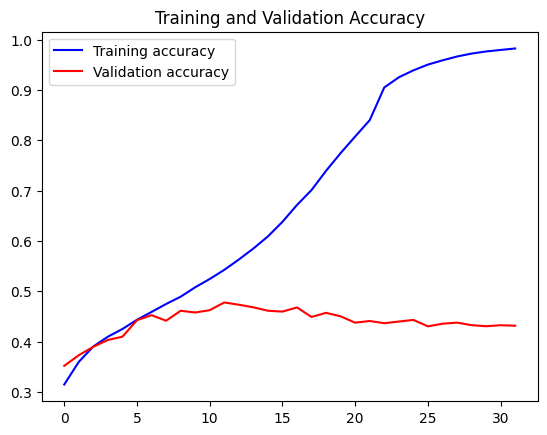

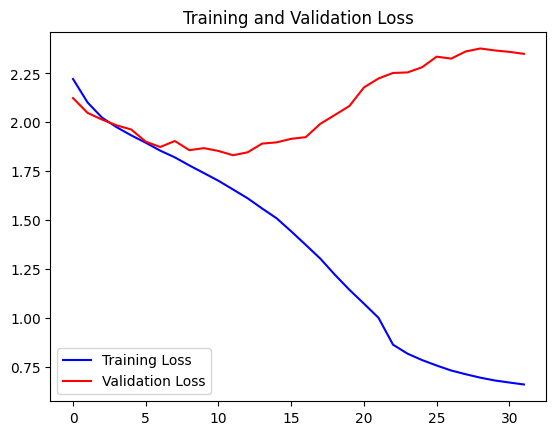

In [83]:
# Normal
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'b', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'b', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# plt.show()

# AlexNet 
acc = history_alexNet.history['accuracy']
val_acc = history_alexNet.history['val_accuracy']
loss = history_alexNet.history['loss']
val_loss = history_alexNet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [86]:
alexNet.evaluate(test_ds)

191/191 [==============================] - 33s 168ms/step - loss: 1.8145 - accuracy: 0.4836


[1.8145239353179932, 0.483622670173645]

1/1 [==============================] - 0s 16ms/step


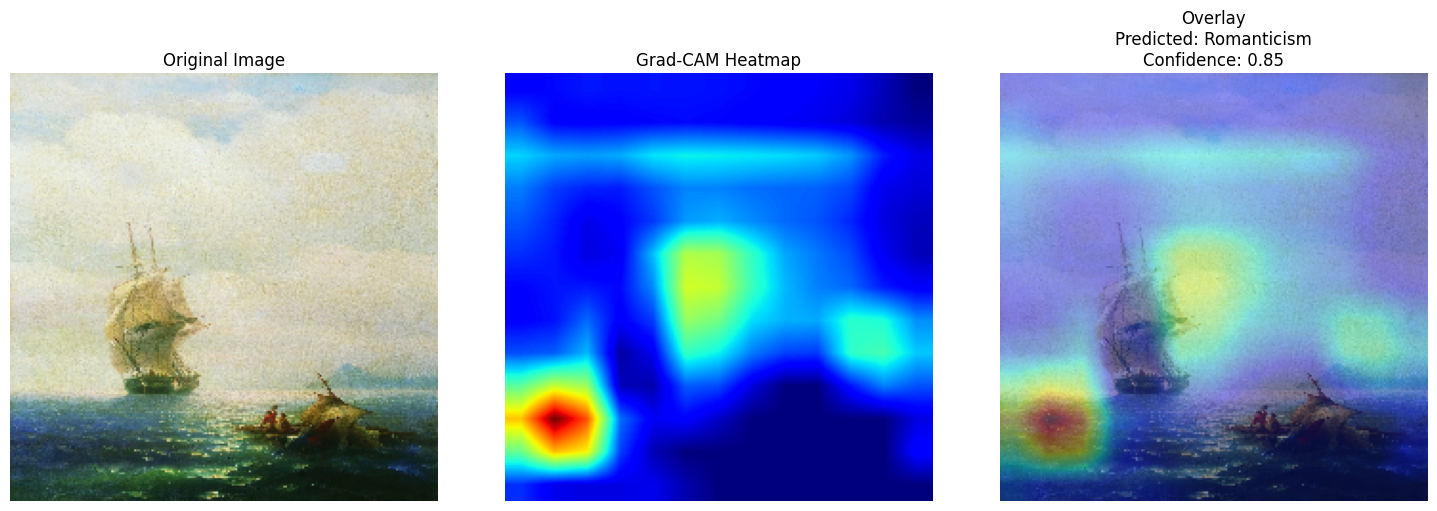

In [100]:
# Grad-CAM implementation
def get_gradcam(model, img_array, layer_name, class_idx=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    
    # Extract the gradients of the top predicted class with regard to the output feature map
    grads = tape.gradient(loss, conv_outputs)
    
    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array by "how important this channel is"
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap between 0 & 1 for visualization purposes
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    # Resize heatmap to original image size
    heatmap = tf.image.resize(tf.expand_dims(heatmap, -1), [image_height, image_width])
    heatmap = tf.squeeze(heatmap)
    
    return heatmap.numpy()

# Visualize Grad-CAM results
def visualize_gradcam(model, image_path, layer_name='conv2d_4'):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width])
    img_array = tf.cast(img, tf.float32) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)
    
    # Get prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    # Generate Grad-CAM heatmap
    heatmap = get_gradcam(model, img_array, layer_name)
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img_array[0])
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(img_array[0])
    axes[2].imshow(heatmap, cmap='jet', alpha=0.4)
    axes[2].set_title(f'Overlay\nPredicted: {grouped_styles[predicted_class]}\nConfidence: {confidence:.2f}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test with a sample image
sample_image_path = X_val_paths[0]
visualize_gradcam(alexNet, sample_image_path, layer_name='conv2d_24')



In [99]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = alexNet.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = y_test_labels
print(classification_report(y_test_classes, y_pred_classes, target_names=styles))

191/191 [==============================] - 21s 109ms/step
                       precision    recall  f1-score   support

   Art_Nouveau_Modern       0.50      0.27      0.35       650
              Baroque       0.49      0.45      0.47       636
 Color_Field_Painting       0.67      0.56      0.61       243
               Cubism       0.40      0.26      0.31       384
        Expressionism       0.35      0.43      0.39      1439
              Fauvism       0.24      0.06      0.10       140
        Impressionism       0.53      0.79      0.63      3002
           Minimalism       0.57      0.48      0.52       200
Naive_Art_Primitivism       0.28      0.14      0.19       361
              Pop_Art       0.34      0.10      0.16       222
              Realism       0.48      0.36      0.41      1729
          Renaissance       0.49      0.69      0.57       985
               Rococo       0.60      0.32      0.42       314
          Romanticism       0.47      0.38      0.42      1

In [101]:
alexNet.save('model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(alexNet)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmpqnwv292l\assets


INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmpqnwv292l\assets
